In [1]:
import keras
keras.__version__

/home/baxter/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.6'

In [2]:
#Read in the grasp images, grasp bboxes and creating the training and testing data arrays
import os
import numpy as np
import math
from PIL import Image
from keras import backend as K
import tensorflow as tf


BASE_DIR = '/media/baxter/DataDisk/Cornell Grasps Dataset/original'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
TARGET_IMAGE_WIDTH = 224
TRAIN_START_INSTANCE = 100 #Initial CGD instance is pcd0100.png & pcd0100cpos.txt
TRAIN_INSTANCE_RANGE = 300 #First 850 instances are for training => (%100:%949)
TEST_START_INSTANCE = 1000 #Initial CGD instance for test data is pcd1000.png & pcd1000cpos.txt
TEST_INSTANCE_RANGE = 1035 #(1000:1034) instances are for testing

In [3]:
#Define functions to convert bboxes to grasps and load images, grasps to numpy arrays
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

def bboxes_to_grasps(box):
    #box = float(box) / TARGET_IMAGE_WIDTH #Refract the pixel locations in unit distances
    
    x = (box[0] + box[2] + box[4] + box[6]) / 4
    y = (box[1] + box[3] + box[5] + box[7]) / 4
    
    div_denominator = box[6] - box[0] #Avoiding the ZeroDivision error in python
    if div_denominator == 0:
        tan = 0.0
    else:
        tan = (box[7] - box[1])/(box[6] - box[0])
        
    h = tf.sqrt(tf.pow(box[2]-box[0], 2) + tf.pow(box[3]-box[1], 2))
    w = tf.sqrt(tf.pow(box[6]-box[0], 2) + tf.pow(box[7]-box[1], 2))
    grasp = [x, y, tan, h, w]
    
    return grasp


def load_image(instance_num, image_dir):
    if instance_num <1000:
        base_filename = 'pcd0'
    else:
        base_filename = 'pcd'
    
    img_filename = os.path.join(image_dir, base_filename + str(instance_num) + "r" + "." + 'png')
    img = io.imread(img_filename)
    #img = img.reshape([TARGET_IMAGE_WIDTH, TARGET_IMAGE_WIDTH, 3])
    
    #Resizing to the preferred size
    image_resized = resize(img, (TARGET_IMAGE_WIDTH, TARGET_IMAGE_WIDTH))
    
    return image_resized


def load_bbox(instance_num, bbox_dir):
    if instance_num <1000:
        base_filename = 'pcd0'
    else:
        base_filename = 'pcd'
    
    filename = os.path.join(bbox_dir, base_filename + str(instance_num) + "cpos" + "." + 'txt')
    with open(filename) as f:
        bbox = list(map(
            lambda coordinate: float(coordinate), f.read().strip().split()))
       
    return bbox


In [4]:
def load_cgd_data(train_start_instance, train_instance_range, test_start_instance, test_instance_range):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    #Loading the training data: (x_train, y_train)
    for instance_num in range(train_start_instance, train_instance_range):
        bboxes = load_bbox(instance_num, TRAIN_DIR)
        #print(bboxes)
        for box_num in range(0, len(bboxes), 8):
            y_train_temp = bboxes_to_grasps(bboxes[box_num:box_num+8])
            #y_train = np.concatenate((y_train, y_train_temp))
            y_train.append(y_train_temp)

            img = load_image(instance_num, TRAIN_DIR)
            #print(img_array.shape)
            x_train.append(img)
         
    y_train = np.array(y_train) #NumPy arrays doesn't have append, so make them arrays out of the for loops
    x_train = np.array(x_train)
    
    #Loading the testing data: (x_test, y_test)
    for instance_num in range(test_start_instance, test_instance_range):
        bboxes = load_bbox(instance_num, TEST_DIR)

        for box_num in range(0, len(bboxes), 8):
            y_test_temp = bboxes_to_grasps(bboxes[box_num:box_num+8])
            y_test.append(y_test_temp)
            
            img = load_image(instance_num, TEST_DIR)
            #print(img_array.shape)
            x_test.append(img)
         
    y_test = np.array(y_test) #NumPy arrays doesn't have append, so make them arrays out of the for loops
    x_test = np.array(x_test)
    
    return x_train, y_train, x_test, y_test

In [5]:
#Reading into the network variables
(x_train, y_train, x_test, y_test) = load_cgd_data(TRAIN_START_INSTANCE,TRAIN_INSTANCE_RANGE,
                                                   TEST_START_INSTANCE,TEST_INSTANCE_RANGE)
print('Successfully read the datasets')
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

/home/baxter/tensorflow/local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Successfully read the datasets
('x_train shape:', (1001, 224, 224, 3), 'y_train shape:', (1001, 5))


In [6]:
#Defining a simple network architecture
from keras.applications import VGG16
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=[224, 224, 3]))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 774400)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               99123328  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 99,143,365
Trainable params: 99,143,365
Non-trainable params: 0
________________________________________________________________

In [7]:
#Splitting the training dataset for one-fold valiadtion in 0.8 for training and 0.2 for validation
split_ratio = 0.8
num_train_samples = int(len(x_train)*split_ratio)

train_data = x_train[0:num_train_samples]
train_targets = y_train[0:num_train_samples]

validation_data = x_train[num_train_samples:len(x_train)]
validation_targets = y_train[num_train_samples:len(x_train)]

#import numpy.ndarray.tolist
#train_data = train_data.tolist()
#train_targets = train_targets.tolist()

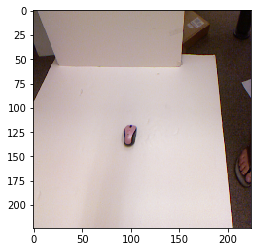

In [23]:
#Validate the value/shape of a data point
import matplotlib.pyplot as plt

train_data.shape
plt.imshow(train_data[115,:,:,:])

In [9]:
#Compile model with custom loss and metric functions using Adam optimizer
from keras import optimizers

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                       epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer='adam', loss='mse')

In [10]:
#Running the training
import numpy as np

#history = model.fit(train_data, train_targets, batch_size=1, epochs=30, verbose=1)


In [11]:
#Defining the custom loss functions and evaluation metrics for the model
import tensorflow as tf
from shapely.geometry import Polygon
import math
from keras import backend as K

def grasps_to_bboxes(grasp):
    #Order of input: x, y, tan, h, w
    bbox = []
    x = grasp[0]
    y = grasp[1]
    tan = grasp[2]
    h = grasp[3]
    w = grasp[4]
    
    theta = tf.atan(tan);
    
    bbox.append(x+((-w/2)*tf.cos(theta))-((-h/2)*tf.sin(theta)))
    bbox.append(y+((-h/2)*tf.cos(theta))+((-w/2)*tf.sin(theta)))
    bbox.append(x+((-w/2)*tf.cos(theta))-((h/2)*tf.sin(theta)))
    bbox.append(y+((h/2)*tf.cos(theta))+((-w/2)*tf.sin(theta)))
    bbox.append(x+((w/2)*tf.cos(theta))-((h/2)*tf.sin(theta)))
    bbox.append(y+((h/2)*tf.cos(theta))+((w/2)*tf.sin(theta)))
    bbox.append(x+((w/2)*tf.cos(theta))-((-h/2)*tf.sin(theta)))
    bbox.append(y+((-h/2)*tf.cos(theta))+((w/2)*tf.sin(theta)))
    
    bbox = np.array(bbox)
    return bbox
    
    
def rsse_loss_function(y_true, y_pred):
    #Order of output: x, y, tan, h, w
    tan_hat = y_pred[2]
    tan_hat_confined = tf.minimum(11., tf.maximum(-11., tan_hat))
    tan = y_true[2]
    tan_confined = tf.minimum(11., tf.maximum(-11., tan))
    gamma = tf.constant(10.)
    loss = tf.pow(y_pred[0] - y_true[0], 2) + tf.pow(y_pred[1] - y_true[1], 2) + gamma*tf.pow(tan_hat_confined - tan_confined, 2) + tf.pow(y_pred[3] - y_true[3], 2) + tf.pow(y_pred[4] - y_true[4], 2)
    loss = tf.sqrt(loss)
    return loss


def _floats_feature(v):
    if not isinstance(v, list):
        v = [v]
    return tf.train.Feature(float_list=tf.train.FloatList(value=v))

def rectangle_metric(y_true, y_pred):
    rec_true = grasps_to_bboxes(y_true)
    rec_pred = grasps_to_bboxes(y_pred)
    
    poly_true = Polygon([(float(rec_true[0]), float(rec_true[1])), 
                         (float(rec_true[2]), float(rec_true[3])),
                         (float(rec_true[4]), float(rec_true[5])),
                         (float(rec_true[6]), float(rec_true[7]))
                        ])
    poly_pred = Polygon([(float(rec_pred[0]), float(rec_pred[1])),
                         (float(rec_pred[2]), float(rec_pred[3])),
                         (float(rec_pred[4]), float(rec_pred[5])),
                         (float(rec_pred[6]), float(rec_pred[7]))
                        ])
    
    iou = poly_true.intersection(poly_pred).area / (poly_true.area +poly_pred.area - poly_true.intersection(poly_pred).area) 
    angle_diff = K.abs(K.atan(y_pred[2])*180/K.pi -K.atan(y_true[2])*180/K.pi)
    
    return iou, angle_diff

In [12]:
from keras import backend as K
import tensorflow as tf

temp_y_true = np.zeros(5)

def model_loss_function(y_true, y_pred):
    #Order of output: x, y, tan, h, w
    tan_hat = y_pred[2]
    tan_hat_confined = tf.minimum(11., tf.maximum(-11., tan_hat))
    tan = temp_y_true[2]
    tan_confined = tf.minimum(11., tf.maximum(-11., tan))
    gamma = tf.constant(10.)
    loss = tf.pow(y_pred[0] - temp_y_true[0], 2) + tf.pow(y_pred[1] - temp_y_true[1], 2) + gamma*tf.pow(tan_hat_confined - tan_confined, 2) + tf.pow(y_pred[3] - temp_y_true[3], 2) + tf.pow(y_pred[4] - temp_y_true[4], 2)

    return loss